### Midiendo tu edad biológica

Los científicos definen dos tipos principales de edad: la *edad cronológica* y la *edad biológica*. La edad cronológica se basa en cuánto tiempo has estado vivo (años desde el nacimiento), mientras que la edad biológica es una estimación aproximada de la salud de tu cuerpo al medir diferentes biomarcadores.
Una forma de determinar la edad biológica es medir los niveles de metilación en tu genoma. En sitios conocidos como sitios CpG, a lo largo de tu ADN, varias proteínas pueden agregar o quitar grupos metilo para controlar qué genes se expresan en proteínas y cuáles no. A medida que envejeces, sin embargo, los sistemas responsables de mantener este control del genoma comienzan a deteriorarse, lo que provoca errores en la metilación.

El Dr. Steve Horvath, investigador de longevidad en la UCLA, utilizó datos de metilación de ADN para desarrollar un sistema conocido como el **reloj de envejecimiento de Horvath** (Horvath clock), que es capaz de generar una estimación precisa de tu edad biológica. Por ejemplo, después de analizar los niveles de metilación en una muestra de tus células, el reloj podría indicarte que tu edad biológica es de alrededor de 30 años, lo que básicamente significa que tus niveles de metilación (y la salud de tu cuerpo) son similares a los de una persona promedio de 30 años. Si tu edad real está alrededor de los 40 años, esto significa que llevas un estilo de vida saludable, mientras que si solo tienes 20 años, esto sugiere que llevas un estilo de vida poco saludable. Esta información proporciona a las personas el conocimiento necesario para tomar el control de su estilo de vida y vivir de manera saludable.

![](https://drive.google.com/uc?export=view&id=1AS3qv-vPv8MzbqCdqBF4DwODA7v4w1dx)

### Explicacion de la actividad

En este notebook vamos a intentar replicar el reloj epigenético desarrollado por Horvath, utilizando datos de metilación tomados de muestras de sangre (X) para predecir la edad de un individuo (y).

El reloj de Horvath fue entrenado con un modelo de regresion lineal. Nosotros entrenaremos maquinas de soporte vectorial utilizando el "kernel trick" para ver si así logramos obtener un reloj epigenetico mas preciso que los disponibles en el mercado.



In [ ]:
#@title Importar los modulos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model


In [ ]:
#@title Conectar y acceder a google drive desde colab

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#@title Importar los datos de metilación de pacientes sanos usando Pandas
!gdown '1EdLxanBA56s09GFbZbhbSDKsf4YGFFdh'
path = "Healthy_Methylation_Dataset.csv"
healthy_df = pd.read_csv(path)
healthy_df.head()

Downloading...
From: https://drive.google.com/uc?id=1EdLxanBA56s09GFbZbhbSDKsf4YGFFdh
To: /content/Healthy_Methylation_Dataset.csv
100% 102k/102k [00:00<00:00, 63.7MB/s]


,...1,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,sex,age
0,GSM507152,0.392464,0.281630,0.352591,0.315924,0.111604,0.211683,1,71.06
1,GSM507153,0.377919,0.238900,0.520396,0.323641,0.127965,0.184307,1,69.65
2,GSM507154,0.458522,0.204078,0.519273,0.363714,0.119891,0.215067,1,65.79
3,GSM507155,0.479108,0.154893,0.618859,0.493972,0.088941,0.240057,1,49.39
4,GSM507156,0.418763,0.217832,0.561005,0.398580,0.085992,0.207462,1,60.68


### Pre-procesamiento de los datos

Aquí primero mezclamos nuestro conjunto de datos para eliminar cualquier factor de confusión que pueda existir como resultado del ordenamiento del conjunto de datos, tal como una división inapropiada entre entrenamiento y prueba. También eliminamos todas las filas con valores faltantes (o NaN) y luego restablecemos los índices.


In [ ]:
# Shuffle dataframe to randomize data order, possibly preventing confounding factors
healthy_df = shuffle(healthy_df)

# Remove patient ID column
healthy_df = healthy_df.drop(['...1'], axis=1)

# Drop all rows with NaN values
healthy_df = healthy_df.dropna()

# Reset Index
healthy_df.reset_index(inplace=True, drop=True)

healthy_df

,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,sex,age
0,0.721220,0.110320,0.623070,0.520210,0.058790,0.331760,0,5.666667
1,0.657510,0.196500,0.833290,0.418770,0.168750,0.370830,0,11.000000
2,0.672330,0.064950,0.727880,0.575410,0.051070,0.328390,0,6.833333
3,0.802000,0.038300,0.814000,0.822000,0.033400,0.383000,0,0.000000
4,0.457203,0.232167,0.797056,0.398047,0.232903,0.262276,0,38.000000
...,...,...,...,...,...,...,...,...
1329,0.577657,0.190553,0.810323,0.383878,0.179863,0.373976,0,20.000000
1330,0.624350,0.082610,0.769260,0.582100,0.050400,0.309020,0,7.250000
1331,0.569190,0.096120,0.724530,0.534250,0.041810,0.299980,0,7.250000
1332,0.680130,0.201120,0.805820,0.439580,0.144150,0.389460,1,5.000000


### Analisis exploratorio de los datos

A continuación, se muestra la matriz de correlación o "mapa de calor", para comparar las variables. Como se puede observar en la fila inferior (etiquetada como edad), los sitios de metilación que podrían ser los mejores predictores de la edad (los más fuertemente correlacionados, ya sea de manera negativa o positiva) son cg09809672, cg01820374 y cg19761273. También observamos que el sexo parece tener una correlación positiva con la edad. Esto sugiere la posible presencia de un factor de confusión que podría surgir debido al conjunto de datos, ya que parece que las mujeres en el conjunto de datos (etiquetadas como 1) son mayores que los hombres (etiquetados como 0).

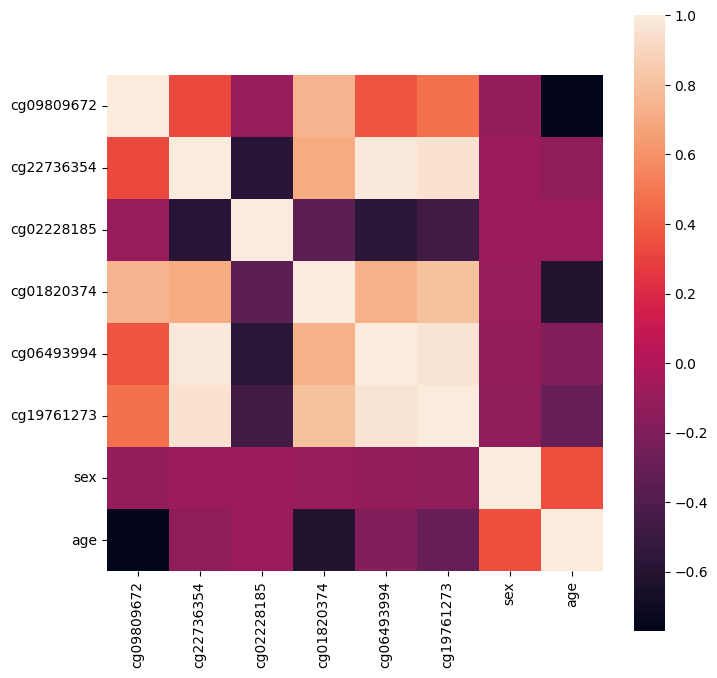

In [ ]:
import seaborn as sb
C_mat = healthy_df.corr()

fig = plt.figure(figsize = (8,8))

sb.heatmap(C_mat, vmax=1, square=True)
plt.show()

### Normalización y division de los datos en conjuntos de entrenamiento y prueba

A continuación guardamos las caracteristicas de entrada (datos de metilación y sexo) y etiquetas (edad) en dos arreglos separados X e y, respectivamente.

Luego normalizamos las caracteristicas de entrada con *StandardScaler* que se utiliza para estandarizar las características al escalarlas a una media cero y una desviación estándar unitaria.

El escalado de datos es una práctica recomendada en la mayoría de los casos para mejorar el rendimiento y la estabilidad de los algoritmos de aprendizaje automático, incluyendo SVM.

Finalmente, dividimos los datos en conjunto de entranamiento y de prueba.  


In [ ]:
# Normalizing the methylation and sex data with a Standard Scaler.
X = healthy_df[['cg09809672', 'cg22736354', 'cg02228185', 'cg01820374', 'cg06493994', 'cg19761273', 'sex']]
y = healthy_df['age']

# Separating X vs. y dataframes
std_scaler = StandardScaler()
X_std = pd.DataFrame(std_scaler.fit_transform(X), columns=X.columns)


In [ ]:
# Separating dataset into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

### Entrenamiento de un modelo de regresion lineal

In [ ]:
# Training the multivariate linear regression model
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(X_train, y_train)


LinearRegression()

### Evaluación del modelo de regresion lineal

Basandonos en el score y en las predicciones impresas a continuación, podemos ver que el modelo de regresión lineal solo es algo capaz de predecir con precisión la edad de un individuo utilizando los niveles de metilación proporcionados, con aproximadamente un 75% de precisión en el conjunto de prueba.







In [ ]:
# Evaluación en el conjunto de prueba (coeficiente de determinación (R-cuadrado))
print(linear_regressor.score(X_test, y_test))

0.7404547420778695


In [ ]:
# Usamos el modelo entrenado para predecir la edad de en el conjunto de prueba
predictions = linear_regressor.predict(X_test)

# Dado que la edad no puede ser negativa, cambio todas las predicciones negativas a una edad de 0 años
for n, element in enumerate(predictions):
    if element < 0:
        predictions[n] = 0

# Inspeccionar algunar predicciones sobre el conjunto de proeba (test)
for i in range(0, 10):
    print("Predicción:", predictions[i], "\tEdad real:", y_test.iloc[i])

Predicción: 49.09430681265821 	Edad real: 53.15
Predicción: 28.217134063817753 	Edad real: 32.0
Predicción: 11.023464019727669 	Edad real: 8.5
Predicción: 34.04403118230916 	Edad real: 30.0
Predicción: 15.60930502838496 	Edad real: 13.0
Predicción: 26.430509113485954 	Edad real: 31.0
Predicción: 48.97008040563222 	Edad real: 38.0
Predicción: 0.0 	Edad real: 0.0
Predicción: 14.383326400380959 	Edad real: 13.75
Predicción: 9.986303504848152 	Edad real: 14.08333333


Veamos si podemos mejorar la capacidad predictiva del modelo usando SVM.

### Maquinas de Soporte Vectorial para Regresión (SVR)

Las máquinas de soporte vectorial (SVM, por sus siglas en inglés) se desarrollaron inicialmente para problemas de clasificación, pero también se pueden adaptar para tareas de regresión. Esta adaptación se conoce como "Máquinas de Soporte Vectorial para Regresión" o "SVR" (Support Vector Regression en inglés).

Recordando, las Máquinas de Soporte Vectorial (SVM) tienen como objetivo encontrar el hiperplano óptimo que mejor separa las dos clases en los datos de entrada. El hiperplano óptimo es aquel que maximiza el margen, que es la distancia entre el hiperplano y los puntos de datos más cercanos de cada clase, conocidos como vectores de soporte.

Similar a las SVM, las SVR utilizan el concepto de un hiperplano y un margen, pero existen diferencias en sus definiciones. En SVR, el margen se define como una región de tolerancia al error del modelo, que también se llama "tubo ε-insensible". Este tubo permite cierta desviación de los puntos de datos con respecto al hiperplano sin que se consideren como errores.  Esto crea un equilibrio entre la complejidad del modelo y su capacidad de generalización. La diferencia entre las SVM y las SVR se resume en la figura que se muestra a continuación.

![](https://drive.google.com/uc?export=view&id=1ifdZoP_U3DT6nzHAW7yTlTozsO28MkVK)



In [ ]:
#@title Entrenamiendo de un modelo SVR
from sklearn.svm import SVR

svr = SVR(kernel='rbf', epsilon=0.1, gamma= 'scale', C=100.0)
svr.fit(X_train, y_train)


SVR(C=100.0)

In [ ]:
#@title Evaluación del modelo SVR
svr.score(X_test, y_test)

0.9141997278169705

In [ ]:
predictions = svr.predict(X_test)

# Dado que la edad no puede ser negativa, cambio todas las predicciones negativas a una edad de 0 años
for n, element in enumerate(predictions):
    if element < 0:
        predictions[n] = 0

# Looking at sample predictions for the testing set
for i in range(0, 10):
  print("Prediccion:", predictions[i],"\tEdad real:", y_test.iloc[i])

Prediccion: 63.34284250985263 	Edad real: 53.15
Prediccion: 31.91915735523823 	Edad real: 32.0
Prediccion: 6.899991248578395 	Edad real: 8.5
Prediccion: 37.997454265540405 	Edad real: 30.0
Prediccion: 13.427532333597007 	Edad real: 13.0
Prediccion: 26.553006449145037 	Edad real: 31.0
Prediccion: 38.23850268528263 	Edad real: 38.0
Prediccion: 0.0 	Edad real: 0.0
Prediccion: 9.266560683014085 	Edad real: 13.75
Prediccion: 7.097603712160286 	Edad real: 14.08333333


Como vemos, el reloj SVR predice un poco mejor la edad de individuos sanos.

A continuación se muestra un grafico de residuos que permite evaluar la calidad del modelo de regresión SVR.

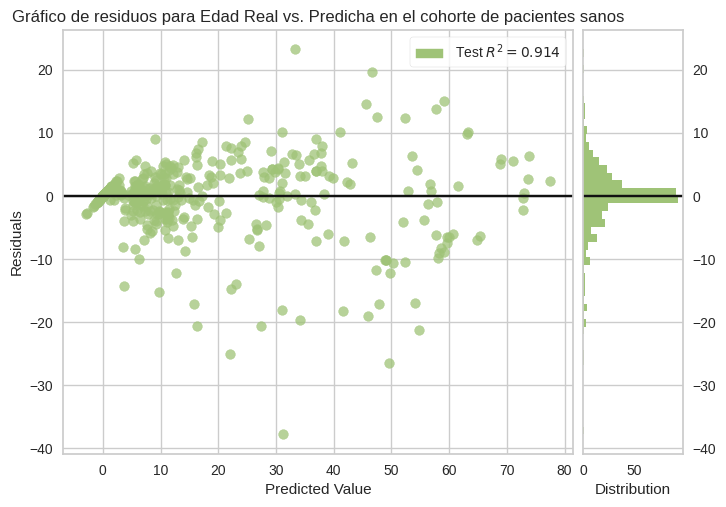

<Axes: title={'center': 'Gráfico de residuos para Edad Real vs. Predicha en el cohorte de pacientes sanos'}, xlabel='Predicted Value', ylabel='Residuals'>

In [ ]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(svr, title="Gráfico de residuos para Edad Real vs. Predicha en el cohorte de pacientes sanos")

visualizer.score(X_test, y_test)
visualizer.show()

### Ajuste de los hiperparámetros
El modelo SVR entrenado mas arriba tiene hiperparámetros que pueden "tunnearse" apara mejorar su capacidad predictiva, incluyendo el kernel, epsilon y C.
Podemos realizar una validacion cruzada utilizando el método GridSearchCV implementado en scikit-learn que permite buscar la mejor combinación de hiperparámetros de un modelo a través de la evaluación de todas las combinaciones posibles de valores de hiperparámetros dentro de un rango especificado.

In [ ]:
from sklearn.model_selection import GridSearchCV


# Define la rejilla de hiperparámetros a buscar
param_grid = {'kernel': ['rbf', 'linear'],
    'epsilon': [0.1, 0.2, 0.5, 0.7, 1.0],
    'C': [1, 10, 100]
}

# Crea un objeto GridSearchCV
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Ajusta el modelo a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Imprime la mejor combinación de hiperparámetros encontrada
grid_search.best_params_

{'C': 100, 'epsilon': 1.0, 'kernel': 'rbf'}

In [ ]:
#@title Reentrenamos el modelo usando el mejor set de hiperparámetros
svr = SVR(kernel=grid_search.best_params_['kernel'], epsilon=grid_search.best_params_['epsilon'], gamma= 'scale', C=grid_search.best_params_['C'])
svr.fit(X_train, y_train)
svr.score(X_test, y_test)


0.9134883993827003

### Prueba en pacientes enfermos

El modelo SVR es capaz de predecir con relativa precisión la edad de individuos sanos basándose en sus niveles de metilación.

Entrenamos el modelo con datos de indivudos sanos porque se supone que en este cohorte la edad biológica no debería diferir demasiado de su edad cronológica.

Sin embargo, es de esperar que personas enfermas muestren niveles de metilación correspondientes a una peor edad biológica. Para probar esta suposicion, importamos un conjunto de datos de alrededor de 627 individuos enfermos (después de eliminar los valores faltantes) y utilizamos el modelo SVR pre-entrenado para comparar la edad biológica predicha con su edad cronológica real.

In [ ]:
#@title Importar los datos de metilación de pacientes enfermos usando Pandas
!gdown '152QqHOqw8OmI0qY3PyrtgzmgRJqY6ige'
path = "Disease_Methylation_Dataset.csv"
disease_df = pd.read_csv(path)
disease_df.head()

Downloading...
From: https://drive.google.com/uc?id=152QqHOqw8OmI0qY3PyrtgzmgRJqY6ige
To: /content/Disease_Methylation_Dataset.csv
100% 47.7k/47.7k [00:00<00:00, 107MB/s]


,Unnamed: 0,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,sex,age
0,GSM501487,0.464046,0.124111,0.523125,0.504438,0.072193,0.260505,1.0,17.0
1,GSM501488,0.488148,0.097101,0.497576,0.399762,0.054484,0.210733,0.0,15.0
2,GSM501489,0.383598,0.159436,0.537074,0.256889,0.086804,0.179779,0.0,13.0
3,GSM501490,0.409324,0.147916,0.592664,0.367384,0.077439,0.230137,0.0,22.0
4,GSM501491,0.665320,0.146727,0.627872,0.420957,0.093538,0.216396,0.0,29.0


In [ ]:
# Remove patient ID column
disease_df = disease_df.drop(['Unnamed: 0'], axis=1)

# Drop all rows with NaN values
disease_df = disease_df.dropna()

disease_df.head()

,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,sex,age
0,0.464046,0.124111,0.523125,0.504438,0.072193,0.260505,1.0,17.0
1,0.488148,0.097101,0.497576,0.399762,0.054484,0.210733,0.0,15.0
2,0.383598,0.159436,0.537074,0.256889,0.086804,0.179779,0.0,13.0
3,0.409324,0.147916,0.592664,0.367384,0.077439,0.230137,0.0,22.0
4,0.665320,0.146727,0.627872,0.420957,0.093538,0.216396,0.0,29.0


In [ ]:
disease_X = disease_df[['cg09809672', 'cg22736354', 'cg02228185', 'cg01820374', 'cg06493994', 'cg19761273', 'sex']]
disease_X = pd.DataFrame(std_scaler.fit_transform(disease_X), columns=disease_X.columns)

disease_Y = disease_df['age']


Nótese que se usó el mismo escalado de datos que se aplicó durante el entrenamiento del modelo. De esta manera nos aseguramos que las predicciones sean comparables.

In [ ]:
disease_predictions = svr.predict(disease_X)

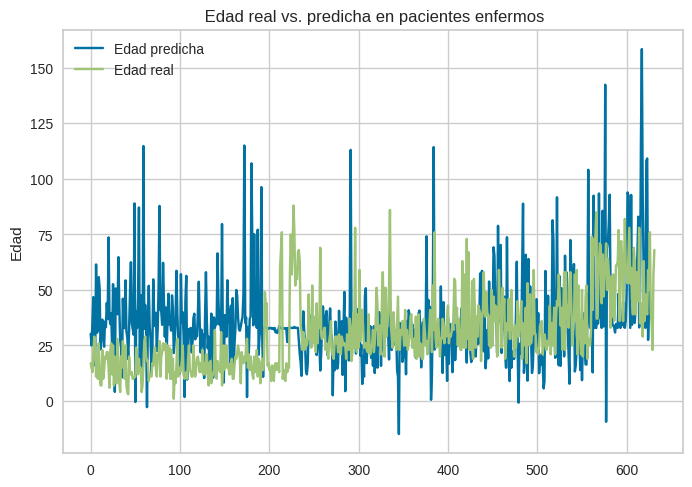

In [ ]:
plt.plot(disease_predictions)
plt.plot(disease_Y)
plt.title(" Edad real vs. predicha en pacientes enfermos")
plt.ylabel('Edad')
plt.legend(['Edad predicha', 'Edad real'], loc='upper left')
plt.show()


Al analizar el gráfico es evidente la presencia de distintos patrones que pueden atribuirse, con alta probabilidad, a la diversidad de cohortes de pacientes que presentan diferentes enfermedades en el conjunto de datos analizado.

Para examinar de manera más precisa los efectos de las distintas enfermedades en la comparación entre la edad predicha y la edad real, procedemos a realizar análisis a una escala más detallada, centrándonos en comparaciones específicas con cada subconjunto de pacientes según su enfermedad.

En particular analizaremos el efecto de la diabetes tipo 1 en la edad biológica.


### Cohorte de pacientes con diabetes tipo 1


In [ ]:
!gdown '1Q75a9QO8O0UFip16OM0VDkflC_JWrf4r'
path = "GSE20067.csv"
GSE20067 = pd.read_csv(path)
GSE20067.head()

Downloading...
From: https://drive.google.com/uc?id=1Q75a9QO8O0UFip16OM0VDkflC_JWrf4r
To: /content/GSE20067.csv
100% 14.7k/14.7k [00:00<00:00, 37.8MB/s]


,Unnamed: 0,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,sex,age
0,GSM501487,0.464046,0.124111,0.523125,0.504438,0.072193,0.260505,1,17
1,GSM501488,0.488148,0.097101,0.497576,0.399762,0.054484,0.210733,0,15
2,GSM501489,0.383598,0.159436,0.537074,0.256889,0.086804,0.179779,0,13
3,GSM501490,0.409324,0.147916,0.592664,0.367384,0.077439,0.230137,0,22
4,GSM501491,0.665320,0.146727,0.627872,0.420957,0.093538,0.216396,0,29


In [ ]:
# Remove patient ID column
GSE20067 = GSE20067.drop(['Unnamed: 0'], axis=1)

# Drop all rows with NaN values
GSE20067 = GSE20067.dropna()

**TAREA 1:**
* Separar las características de entrada y de salida en dos arreglos X e y, respectivamente.
* Realizar el escalado de las caracteristicas en X
* Predecir la edad biológica de los pacientes con diabetes tipo 1
* Graficar Edad real vs predicha
* ¿Que puede decir respecto de la influencia de la diabetes tipo 1 sobre la edad biológica de una persona?


**TAREA 2:**

* Entrene un modelo SVR con kernel polinómico utilizando los datos de entrenamiento (X_train, y_train). Utilice **GridSearchCV** para buscar la mejor combinación de hiperparámetros, ajustando tambien el hiperparámetro *degree* que define el grado del polinomio.
* Evalue la calidad del modelo en el conjunto de prueba (X_test, y_test).